# **Seminário Inteligência Artificial MESC - 2024-T4**
#
## Rafael Medeiros e Orlando Nascimento
## Ferramenta: Facebook Prophet
##
### **Tarefas**
* Investigar dados faltantes
* Investigar outliers
* Identificar tendências
* Identificar sazonalidades
* Identificar autocorrelação
### **Métricas de avaliação**
* MAPE
* MSE
* RMSE

Nessa primeira etapa, além de importar as bibliotecas necessárias, renomeamos a coluna alvo, Turbidity, e a coluna referente as datas para o padrão esperado pelo Prophet.

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv("../data/water_quality_with_agg_data.csv")
df["Data"] = pd.to_datetime(df["Data"])
df.loc[df['MeanTemperature'].isnull(), 'MeanTemperature'] = 23

df.rename(columns={'Data': 'ds', 'Turbidity': 'y'}, inplace=True)
df.head()

,ds,y,pH,Alkalinity,DissolvedOxygen,RainAccumulation1D,RainAccumulation2D,RainAccumulation3D,RainAccumulation4D,RainAccumulation5D,RainAccumulation6D,RainAccumulation7D,RainAccumulation15D,RainAccumulation30D,RiverLevel,MeanTemperature
0,2018-01-01,7.367186,6.845486,25.788530,6.715897,0.001155,2.794847,2.318741,1.460683,9.169686,26.207817,19.561825,103.933015,52.559659,12.005540,26.183333
1,2018-01-02,35.755183,6.807069,19.943425,5.233228,0.001092,0.255247,0.718060,1.446020,2.584408,14.293565,19.873974,7.830140,25.022983,11.948240,27.616667
2,2018-01-03,9.341618,6.906234,19.910010,5.856647,0.012032,0.013785,0.029363,0.007139,0.389962,1.203419,4.060543,12.905984,-0.510383,11.890858,27.250000
3,2018-01-04,16.105204,6.817615,20.249162,6.004393,0.002139,1.929273,0.788018,0.679701,1.694040,7.949185,9.757877,10.163177,52.038419,11.993244,24.500000
4,2018-01-05,16.531502,7.045985,18.217803,6.050563,0.002479,1.077661,0.135524,0.618780,5.573755,8.767472,24.552537,2.447773,33.673292,12.046827,23.820833


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2373 non-null   datetime64[ns]
 1   y                    2373 non-null   float64       
 2   pH                   2373 non-null   float64       
 3   Alkalinity           2373 non-null   float64       
 4   DissolvedOxygen      2373 non-null   float64       
 5   RainAccumulation1D   2373 non-null   float64       
 6   RainAccumulation2D   2373 non-null   float64       
 7   RainAccumulation3D   2373 non-null   float64       
 8   RainAccumulation4D   2373 non-null   float64       
 9   RainAccumulation5D   2373 non-null   float64       
 10  RainAccumulation6D   2373 non-null   float64       
 11  RainAccumulation7D   2373 non-null   float64       
 12  RainAccumulation15D  2373 non-null   float64       
 13  RainAccumulation30D  2373 non-nul

### Observações do dataframe:

- Garantimos que a coluna correspondente a datas já esteja no formato correto, datetime.
- Identificamos também que não existe a presença de dados faltantes no dataframe.
- Identificamos também que os dados adicionados da temperatura também não possuem dados faltantes após adicionar a temperatura média faltante em uma das datas, usamos a internet para encontrar qual era essa temperatura.

19:10:34 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing


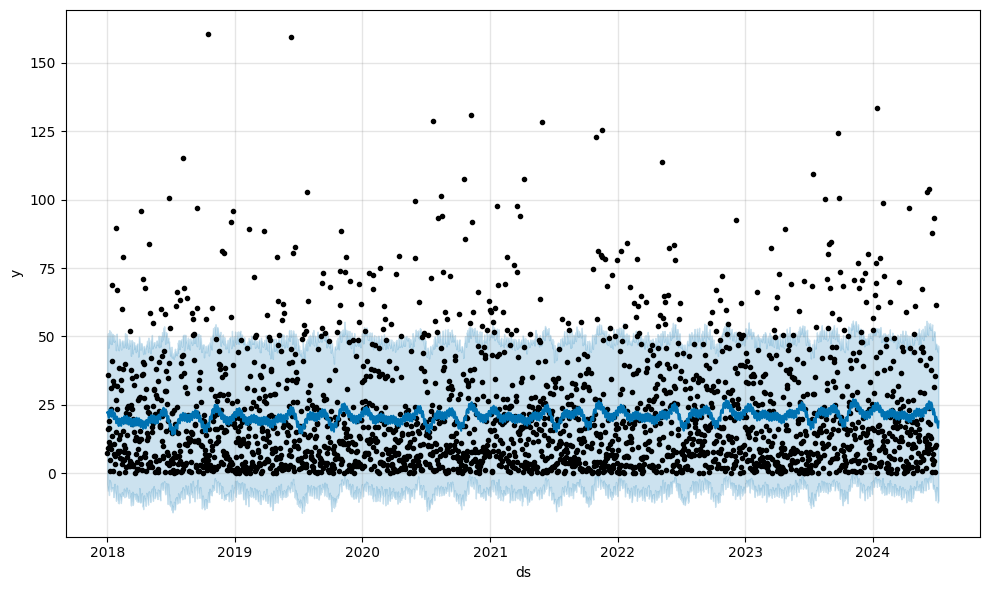

In [3]:

from sklearn.preprocessing import StandardScaler

# Normalizar os regressores selecionados
selected_regressors = ['RainAccumulation30D', 'RainAccumulation15D', 'RainAccumulation7D',
                       'RainAccumulation6D', 'RainAccumulation5D']
scaler = StandardScaler()
data_csv[selected_regressors] = scaler.fit_transform(data_csv[selected_regressors])

# Criar o modelo Prophet com regressores
model = Prophet()
for regressor in selected_regressors:
    model.add_regressor(regressor)

# Ajustar o modelo
model.fit(data_csv[['Data', 'Turbidity'] + selected_regressors].rename(columns={'Data': 'ds', 'Turbidity': 'y'}))

# Previsão
future = model.make_future_dataframe(periods=7)
for regressor in selected_regressors:
    future[regressor] = scaler.transform(data_csv[regressor].tail(7).values.reshape(-1, 1))

forecast = model.predict(future)

# Visualizar o resultado
fig = model.plot(forecast)
plt.show()


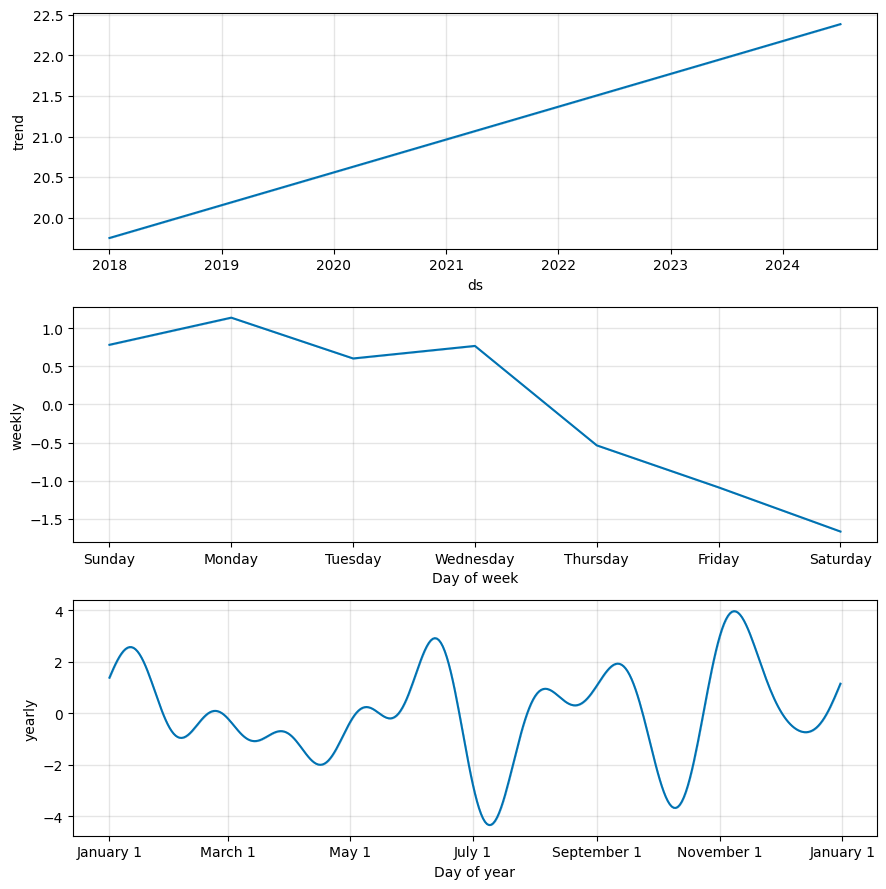

In [4]:
fig2 = model.plot_components(forecast)
plt.show()

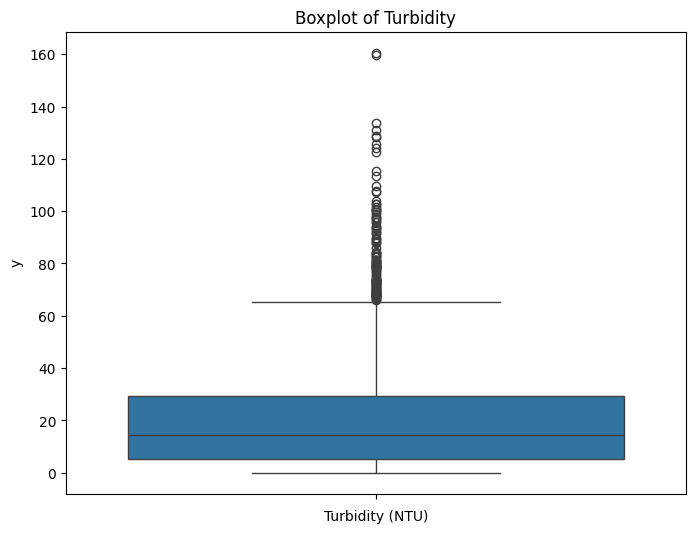

In [5]:
plt.figure(figsize=(8, 6))
sns.boxplot(df['y'])
plt.title('Boxplot of Turbidity')
plt.xlabel('Turbidity (NTU)')
plt.show()

### Observações da Análise Inicial:

1. **Tendência Temporal**:
   - O gráfico de turbidez ao longo do tempo mostra variações significativas, com picos e vales.
   - Existe uma tendência de alta na turbidez que vem desde 2018 até o ano atual (2024). 
   - Não há uma tendência linear clara dentro dos anos; flutuações podem estar relacionadas a fatores ambientais, ou às férias e a mudança no fluxo de pessoas perto do rio, devido aos picos de junho e novembro-dezembro.

3. **Outliers**:
   - O boxplot indica a presença de outliers na turbidez, com alguns valores muito acima do intervalo interquartil.
   - Dependendo do impacto desses valores, podemos optar por tratá-los antes de realizar a previsão.


<Figure size 1200x600 with 0 Axes>

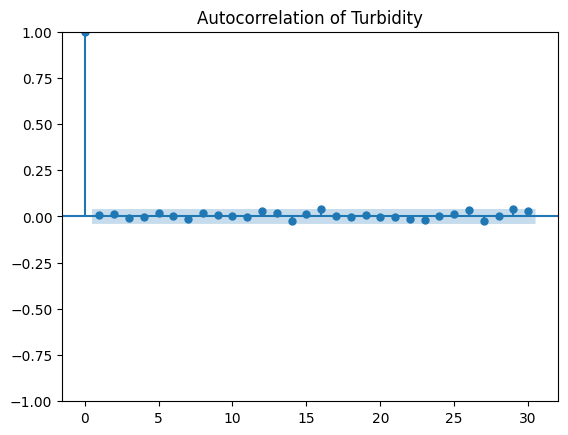

<Figure size 1200x600 with 0 Axes>

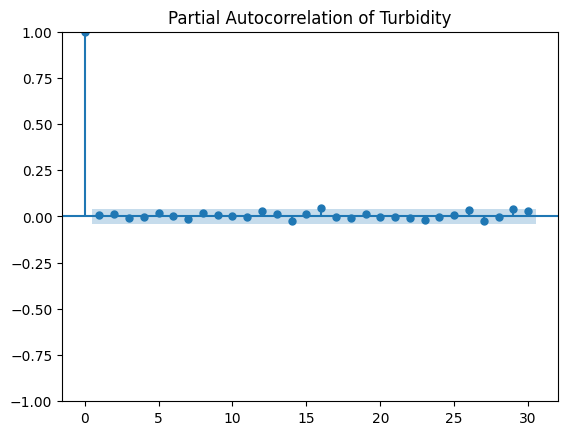

In [6]:
plt.figure(figsize=(12, 6))
plot_acf(df['y'], lags=30, title='Autocorrelation of Turbidity')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['y'], lags=30, title='Partial Autocorrelation of Turbidity')
plt.show()

### Observações de Autocorrelação

1. **Autocorrelação (ACF)**:
   - A função de autocorrelação mostra que há dependência temporal em atrasos (lags) menores, mas ela diminui rapidamente.
   - Isso sugere que os valores de turbidez podem ser influenciados por eventos recentes, mas o impacto de eventos mais antigos é menor.

2. **Autocorrelação Parcial (PACF)**:
   - A PACF indica correlação significativa nos primeiros atrasos, especialmente no lag 1, o que sugere que os valores imediatos anteriores são os mais relevantes.


### Métricas iniciais

In [7]:

actual = df['y'][-7:].reset_index(drop=True)
predicted = forecast['yhat'][-7:].reset_index(drop=True)

mape = mean_absolute_percentage_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5

print(f"MAPE: {mape}\nMSE: {mse}\nRMSE: {rmse}")

MAPE: 5.719781421447971
MSE: 448.2056786201133
RMSE: 21.170868631686165


In [8]:
all_possible_regressors = list(df.columns)
all_possible_regressors = all_possible_regressors[2:] #Removendo 'ds' e 'y' dos regressores
all_possible_regressors

['pH',
 'Alkalinity',
 'DissolvedOxygen',
 'RainAccumulation1D',
 'RainAccumulation2D',
 'RainAccumulation3D',
 'RainAccumulation4D',
 'RainAccumulation5D',
 'RainAccumulation6D',
 'RainAccumulation7D',
 'RainAccumulation15D',
 'RainAccumulation30D',
 'RiverLevel',
 'MeanTemperature']

In [14]:
correlations = df.corr()['y']

sorted_correlations = correlations.drop('y').sort_values(ascending=False)

print(sorted_correlations)

RainAccumulation30D    0.517196
RainAccumulation15D    0.386579
RainAccumulation7D     0.309704
RainAccumulation6D     0.269248
RainAccumulation5D     0.253553
RainAccumulation4D     0.230239
RainAccumulation2D     0.223179
RainAccumulation1D     0.198410
Alkalinity             0.070485
RainAccumulation3D     0.055920
ds                     0.035291
RiverLevel             0.026931
MeanTemperature        0.023516
DissolvedOxygen       -0.057430
pH                    -0.057498
Name: y, dtype: float64


### Análise de Correlação de regressores com Turbidity

- Os regressores que possuem maior correlação com a turbidez são os relacionados ao acumulado de chuva de 5+ dias.
- Esses regressores serão normalizados e uma nova versão do Prophet() com eles será criada.

In [9]:
from sklearn.preprocessing import StandardScaler

selected_regressors = ['RainAccumulation30D', 'RainAccumulation15D', 'RainAccumulation7D',
                       'RainAccumulation6D', 'RainAccumulation5D']
scaler = StandardScaler()
data_csv[selected_regressors] = scaler.fit_transform(data_csv[selected_regressors])

model = Prophet()
for regressor in selected_regressors:
    model.add_regressor(regressor)

model.fit(data_csv[['Data', 'Turbidity'] + selected_regressors].rename(columns={'Data': 'ds', 'Turbidity': 'y'}))

future = model.make_future_dataframe(periods=7)
for regressor in selected_regressors:
    future[regressor] = scaler.transform(data_csv[regressor].tail(7).values.reshape(-1, 1))

forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

19:10:35 - cmdstanpy - INFO - Chain [1] start processing
19:10:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\User\AppData\Local\Temp\ipykernel_15044\3852696095.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future[regressor].fillna(df[regressor].mean(), inplace=True)  # Substituir pela média


MAPE: 5.548266916561018
MSE: 434.31095869583623
RMSE: 20.84012856716187


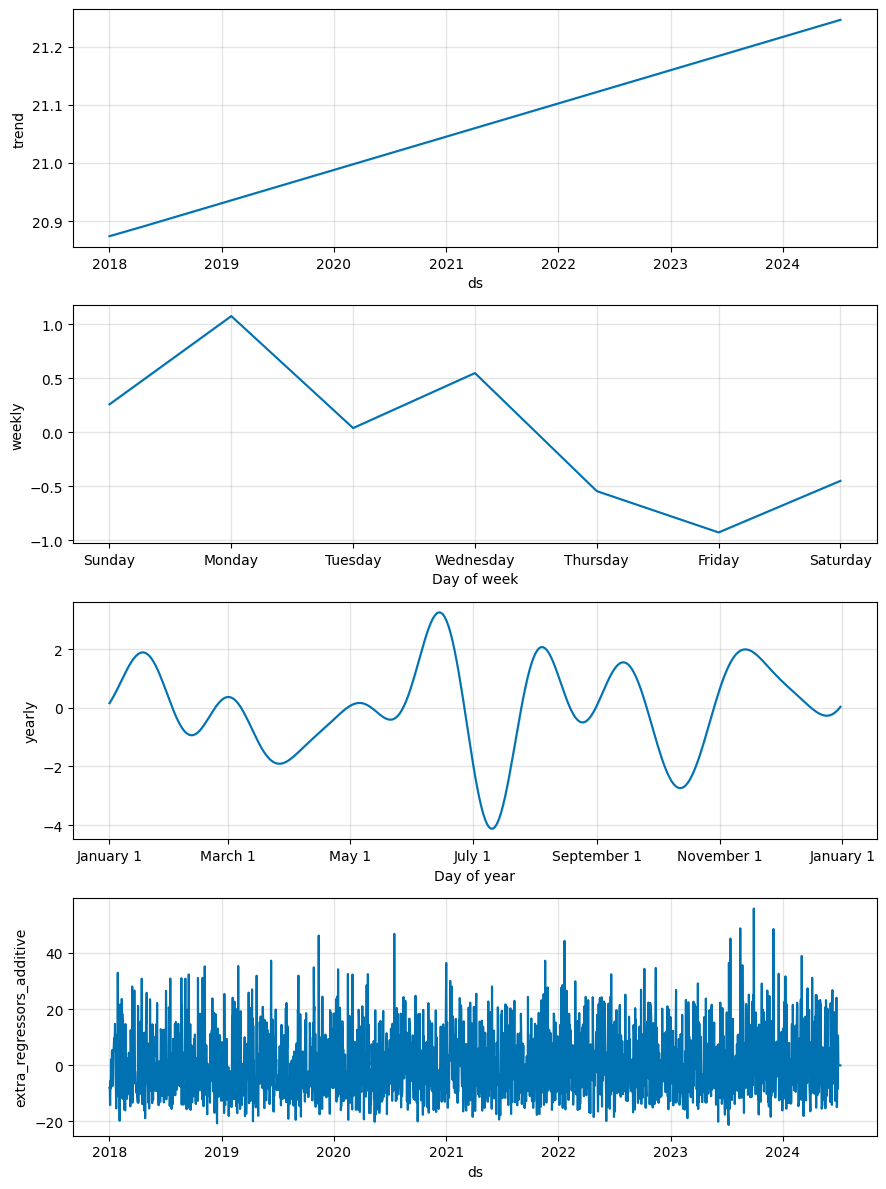

In [10]:
fig2 = model.plot_components(forecast)
plt.show()

In [1]:
#for regressor in regressors:
#    sns.scatterplot(data=df, x=regressor, y='y')
#    plt.title(f'Relação entre {regressor} e y')
#    plt.show()

### Análise de Resultados

Após a inclusão dos regressores selecionados no modelo Prophet, os resultados das métricas de desempenho apresentaram pequenas melhoras:

1. **MAPE** (Mean Absolute Percentage Error): 
   - Antes: **5.72%** 
   - Depois: **5.55%**
   - **Melhoria de ~2.96%.**

2. **MSE** (Mean Squared Error): 
   - Antes: **448.21**
   - Depois: **434.31**
   - **Redução de ~3.1%.**

3. **RMSE** (Root Mean Squared Error): 
   - Antes: **21.17**
   - Depois: **20.84**
   - **Redução de ~1.56%.**

### Interpretação

A adição dos regressores relacionados ao acúmulo de chuva ao modelo Prophet contribuiu para uma leve melhora na capacidade preditiva. A redução no MAPE indica maior precisão relativa nas previsões, enquanto as reduções no MSE e RMSE apontam para uma menor variabilidade e menor magnitude de erros absolutos.

Essas melhorias sugerem que as variáveis adicionadas como regressores têm relevância significativa no comportamento da variável alvo (`Turbidity`), especialmente ao capturar padrões relacionados a eventos climáticos acumulativos.